In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = "prithvimk"
os.environ['KAGGLE_KEY'] = "c49355ce6abe30bd2cdf219e9fdf41d9"

In [3]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 97%|██████████████████████████████████████▋ | 721M/745M [00:14<00:00, 49.8MB/s]
100%|████████████████████████████████████████| 745M/745M [00:14<00:00, 55.4MB/s]


In [4]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
  inflating: COVID-19_Radiography_Dataset/COVID.metadata.xlsx  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-10.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-100.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1000.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1001.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1002.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1003.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1004.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1005.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1006.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1007.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1008.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-1009.png  
  inflating: COVID-19_Radiography_Dataset/COVID/COVID-

In [5]:
import glob
import random
import matplotlib.pyplot as plt
import cv2

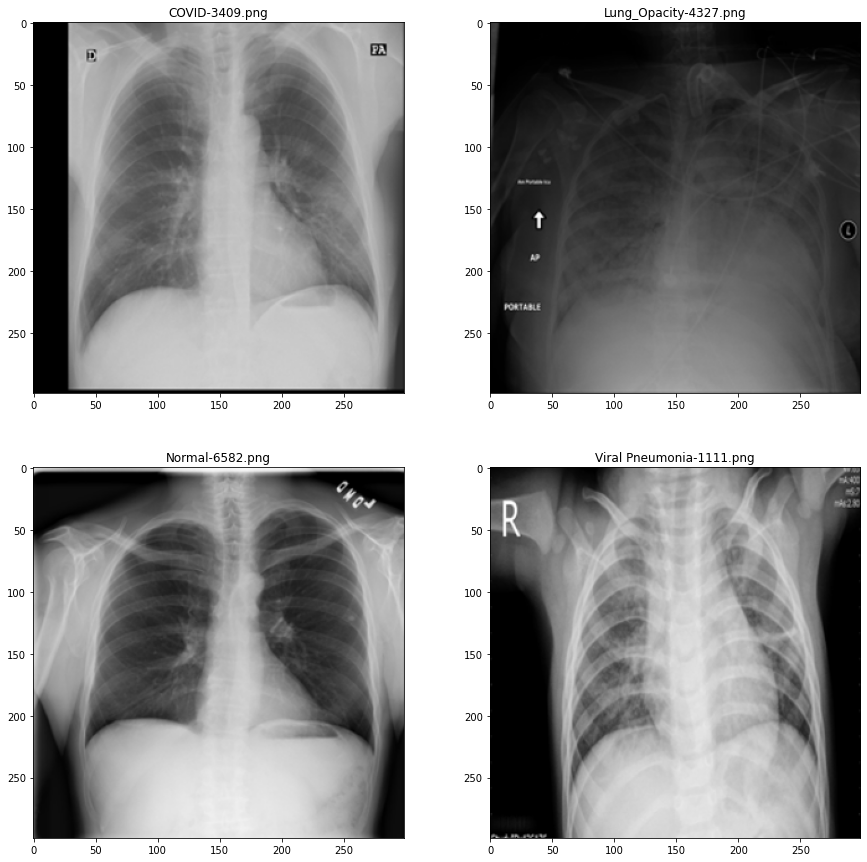

In [6]:
covid = r'./COVID-19_Radiography_Dataset/COVID'
lung_opacity = r'./COVID-19_Radiography_Dataset/Lung_Opacity'
normal = r'./COVID-19_Radiography_Dataset/Normal'
viral_pneumonia = r'./COVID-19_Radiography_Dataset/Viral Pneumonia'

filepath_type = [covid+"/*.png",  lung_opacity+"/*.png", normal+"/*.png", viral_pneumonia+"/*.png"]
random_images = []

for path in filepath_type:
    images = glob.glob(path)
    #print(images)
    random_image_path = random.choice(images)
    random_images.append(random_image_path)

_, axs = plt.subplots(2, 2, figsize=(15,15))
axs = axs.flatten()
for img, ax in zip(random_images, axs):
    ax.title.set_text(img.split('/')[3])
    ax.imshow(cv2.imread(img))
plt.show()

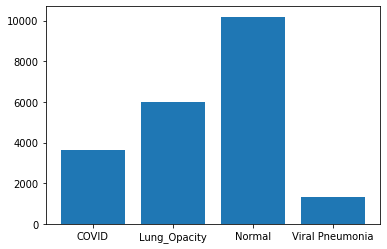

In [7]:
num_of_images = [len(glob.glob(path)) for path in filepath_type]
plt.bar([f.split("/")[2] for f in filepath_type], num_of_images)
plt.show()

In [8]:
from os import makedirs

In [9]:
# create directories
dataset_home = './dataset_covid/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['covid/', 'lung_opacity/', 'normal/', 'viral_pneumonia/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)

In [10]:
from pathlib import Path
from shutil import copyfile
import os

In [11]:
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directories = [covid, lung_opacity, normal, viral_pneumonia]

for path in filepath_type:
    images = glob.glob(path)
    for image in images:
        # storing the path of image as 'src'
        src = Path(image)
        dst_dir = 'train/'
        if random.random() < val_ratio:
            dst_dir = 'test/'
        filename = os.path.basename(src)
        if filename.startswith('COVID'):
            dst = dataset_home + dst_dir + 'covid/' + filename
            copyfile(src, dst)
        elif filename.startswith('Lung_Opacity'):
            dst = dataset_home + dst_dir + 'lung_opacity/' + filename
            copyfile(src, dst)
        elif filename.startswith('Normal'):
            dst = dataset_home + dst_dir + 'normal/' + filename
            copyfile(src, dst)
        elif filename.startswith('Viral Pneumonia'):
            dst = dataset_home + dst_dir + 'viral_pneumonia/' + filename
            copyfile(src, dst)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
input_shape = (256, 256)

In [14]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_it = train_datagen.flow_from_directory('./dataset_covid/train/',
                                       class_mode='categorical',
                                       batch_size=64,
                                       target_size=input_shape)
test_it = test_datagen.flow_from_directory('./dataset_covid/test/',
                                       class_mode='categorical',
                                       batch_size=64,
                                       shuffle=False,
                                       target_size=input_shape)

Found 15806 images belonging to 4 classes.
Found 5359 images belonging to 4 classes.


In [15]:
from sklearn.utils import class_weight
import numpy as np

In [16]:
class_weights = class_weight.compute_class_weight(
                class_weight='balanced',
                classes=np.unique(train_it.classes), 
                y=train_it.classes)

cw_dict = dict(zip(np.unique(train_it.classes), class_weights))
cw_dict

{0: 1.4727916511367871,
 1: 0.8757757092198581,
 2: 0.518637616485103,
 3: 3.983366935483871}

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

In [18]:
base_model = ResNet50(weights= None, include_top=False, input_shape= (input_shape[0], input_shape[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(4, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

2022-01-12 08:30:41.346946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:30:41.455665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:30:41.456720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 08:30:41.458062: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [20]:
checkpoint_path = "./training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr, cp_callback]
adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
history = model.fit(train_it, validation_data=test_it, class_weight=cw_dict, epochs=100, callbacks=callbacks_list)

2022-01-12 08:30:47.785624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-12 08:30:54.837469: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


247/247 [==============================] - 322s 1s/step - loss: 1.4954 - accuracy: 0.4457 - val_loss: 6.3966 - val_accuracy: 0.0659

Epoch 00001: saving model to ./training_1/cp.ckpt
Epoch 2/100
247/247 [==============================] - 310s 1s/step - loss: 1.0089 - accuracy: 0.6039 - val_loss: 2.0777 - val_accuracy: 0.2765

Epoch 00002: saving model to ./training_1/cp.ckpt
Epoch 3/100
247/247 [==============================] - 311s 1s/step - loss: 0.8083 - accuracy: 0.6659 - val_loss: 3.7158 - val_accuracy: 0.4798

Epoch 00003: saving model to ./training_1/cp.ckpt
Epoch 4/100
247/247 [==============================] - 305s 1s/step - loss: 0.7250 - accuracy: 0.6994 - val_loss: 1.4051 - val_accuracy: 0.5339

Epoch 00004: saving model to ./training_1/cp.ckpt
Epoch 5/100
247/247 [==============================] - 313s 1s/step - loss: 0.6681 - accuracy: 0.7212 - val_loss: 0.9265 - val_accuracy: 0.6731

Epoch 00005: saving model to ./training_1/cp.ckpt
Epoch 6/100
247/247 [================

In [24]:
model.save('./CovidModelwithLRDecay_kaggle.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
model.save_weights('./CovidModelwithLRDecay_kaggle_weights.h5')

In [26]:
import json

In [27]:
model_json = model.to_json()
with open('./CovidModelwithLRDecay_kaggle.json', 'w') as file:
    json.dump(model_json, file)

In [28]:
import pickle

In [29]:
with open('./trainHistoryDict.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [30]:
import pandas as pd

<AxesSubplot:>

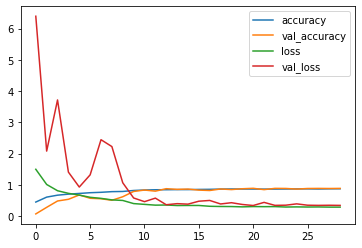

In [31]:
pd.DataFrame({k:model.history.history[k] for k in ['accuracy', 'val_accuracy', 'loss', 'val_loss']}).plot()

In [32]:
test_acc = model.evaluate(test_it)
print('Testing Accuracy: ', test_acc[1])

84/84 [==============================] - 24s 285ms/step - loss: 0.3387 - accuracy: 0.8834
Testing Accuracy:  0.8833737373352051


In [33]:
pred = model.predict(test_it, verbose=1)

84/84 [==============================] - 23s 262ms/step


In [34]:
predictions = pred.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

<AxesSubplot:>

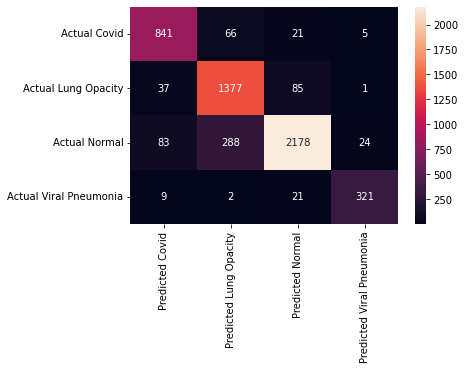

In [36]:
cm = pd.DataFrame(data=confusion_matrix(test_it.classes, np.argmax(predictions, axis=1), labels=[0, 1, 2, 3]),
                  index=["Actual Covid",   "Actual Lung Opacity", "Actual Normal",  "Actual Viral Pneumonia"],
                  columns=["Predicted Covid", "Predicted Lung Opacity", "Predicted Normal", "Predicted Viral Pneumonia"])

sns.heatmap(cm, annot=True, fmt="d")

In [37]:
print(classification_report(y_true=test_it.classes, 
                            y_pred=np.argmax(predictions, axis=1),
                            target_names=['COVID', 'LUNG OPACITY', 'NORMAL', 'VIRAL PNEUMONIA']))

                 precision    recall  f1-score   support

          COVID       0.87      0.90      0.88       933
   LUNG OPACITY       0.79      0.92      0.85      1500
         NORMAL       0.94      0.85      0.89      2573
VIRAL PNEUMONIA       0.91      0.91      0.91       353

       accuracy                           0.88      5359
      macro avg       0.88      0.89      0.89      5359
   weighted avg       0.89      0.88      0.88      5359

